<a href="https://colab.research.google.com/github/Marvin2798/CNN-Project-/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Link : https://github.com/ironhack-labs/project-1-deep-learning-image-classification-with-cnn/blob/main/README.md#project-i--deep-learning-image-classification-with-cnn

1. Loading and Data Processing

In [85]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [86]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [87]:
# Import to_categorical
from tensorflow.keras.utils import to_categorical  # Import to_categorical

In [88]:
# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

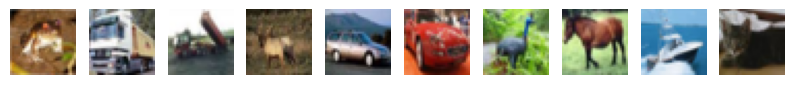

In [89]:
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()


2. Model Architecture

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Define Cutout function
def cutout(image, mask_size=8):
    # Get the height, width, and channels of the image
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    channels = tf.shape(image)[-1]

    # Create random center points for the cutout mask
    center_y = tf.random.uniform([], minval=0, maxval=height, dtype=tf.int32)
    center_x = tf.random.uniform([], minval=0, maxval=width, dtype=tf.int32)

    # Calculate the lower and upper bounds of the mask
    lower_y = tf.clip_by_value(center_y - mask_size // 2, 0, height)
    upper_y = tf.clip_by_value(center_y + mask_size // 2, 0, height)
    lower_x = tf.clip_by_value(center_x - mask_size // 2, 0, width)
    upper_x = tf.clip_by_value(center_x + mask_size // 2, 0, width)

    # Create the mask: ones everywhere, but zeros where the cutout is applied
    mask = tf.ones((height, width, channels), dtype=tf.float32)
    cutout_area = tf.zeros((upper_y - lower_y, upper_x - lower_x, channels), dtype=tf.float32)

    # Apply the mask to the selected area
    mask = tf.tensor_scatter_nd_update(mask,
                                       indices=[[lower_y, lower_x]],
                                       updates=[cutout_area])

    # Apply the mask to the image (cutout region is set to 0)
    return image * mask

# Define the model with enhanced data augmentation
model = Sequential()
model.add(Input(shape=(32, 32, 3)))

# Advanced data augmentation layers
model.add(RandomFlip("horizontal"))   # Flip the image horizontally
model.add(RandomRotation(0.2))        # Rotate the image by 20%
model.add(RandomZoom(0.2))            # Zoom the image by 20%
model.add(RandomContrast(0.2))        # Adjust contrast by 20%
model.add(GaussianNoise(0.1))         # Add Gaussian noise

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fourth Convolutional Block
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.4))

# Output layer
model.add(Dense(10, activation='softmax'))

# Compile the model with categorical_crossentropy
#model.compile(optimizer=Adam(learning_rate=1e-4),
  #            loss='categorical_crossentropy',
  #            metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])


In [91]:
# Display the model
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_30 (RandomFlip  (None, 32, 32, 3)         0         
 )                                                               
                                                                 
 random_rotation_30 (Random  (None, 32, 32, 3)         0         
 Rotation)                                                       
                                                                 
 random_zoom_30 (RandomZoom  (None, 32, 32, 3)         0         
 )                                                               
                                                                 
 random_contrast_30 (Random  (None, 32, 32, 3)         0         
 Contrast)                                                       
                                                                 
 gaussian_noise_27 (Gaussia  (None, 32, 32, 3)       

3. Model Training

In [92]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor="val_loss", mode="min", save_best_only=True, verbose=1)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, checkpoint, reduce_lr])


Epoch 1/50
781/782 [============================>.] - ETA: 0s - loss: 2.1298 - accuracy: 0.2385
Epoch 1: val_loss improved from inf to 2.20869, saving model to best_model.keras
782/782 [==============================] - 35s 41ms/step - loss: 2.1298 - accuracy: 0.2384 - val_loss: 2.2087 - val_accuracy: 0.2495 - lr: 1.0000e-04
Epoch 2/50
781/782 [============================>.] - ETA: 0s - loss: 1.9520 - accuracy: 0.3227
Epoch 2: val_loss improved from 2.20869 to 2.05252, saving model to best_model.keras
782/782 [==============================] - 32s 41ms/step - loss: 1.9521 - accuracy: 0.3227 - val_loss: 2.0525 - val_accuracy: 0.3275 - lr: 1.0000e-04
Epoch 3/50
782/782 [==============================] - ETA: 0s - loss: 1.8858 - accuracy: 0.3558
Epoch 3: val_loss did not improve from 2.05252
782/782 [==============================] - 32s 41ms/step - loss: 1.8858 - accuracy: 0.3558 - val_loss: 2.0572 - val_accuracy: 0.3310 - lr: 1.0000e-04
Epoch 4/50
781/782 [============================>


  4. Model Evaluation



In [94]:
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


313/313 [==============================] - 2s 7ms/step - loss: 1.3772 - accuracy: 0.6075
Validation Loss: 1.3771611452102661
Validation Accuracy: 0.6075000166893005


In [95]:
from sklearn.metrics import classification_report

# Predict the labels on the validation set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Print the classification report
print(classification_report(y_true, y_pred_classes))


313/313 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1000
           1       0.68      0.77      0.72      1000
           2       0.42      0.63      0.50      1000
           3       0.47      0.44      0.46      1000
           4       0.61      0.40      0.48      1000
           5       0.53      0.60      0.56      1000
           6       0.74      0.66      0.70      1000
           7       0.73      0.61      0.67      1000
           8       0.62      0.86      0.72      1000
           9       0.81      0.47      0.59      1000

    accuracy                           0.61     10000
   macro avg       0.63      0.61      0.61     10000
weighted avg       0.63      0.61      0.61     10000



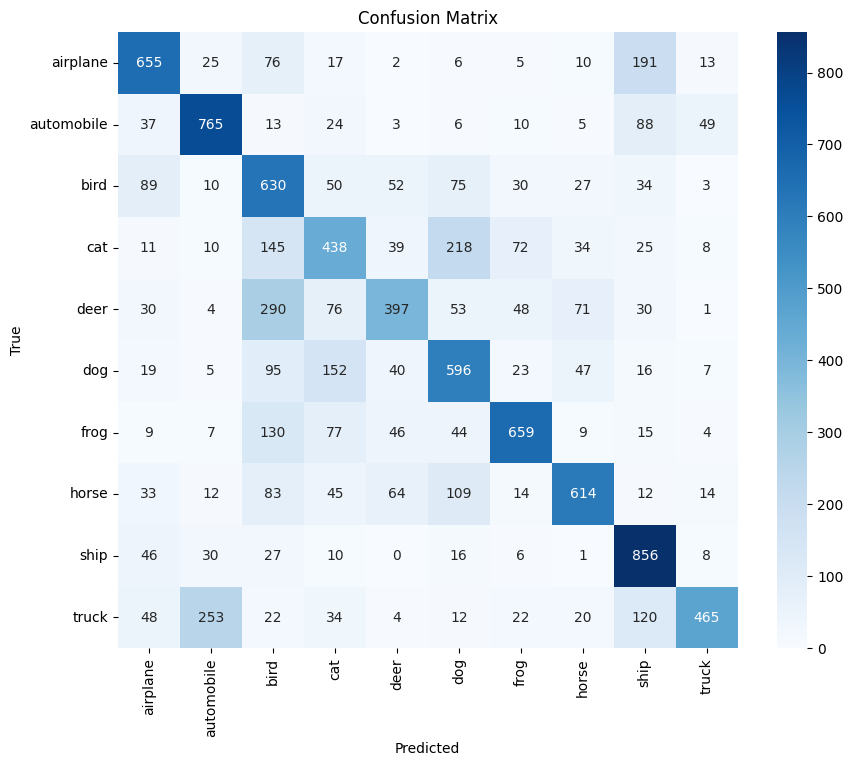

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Transfer Learning using VGG16

In [101]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load and preprocess CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize the data (VGG16 expects input range from 0 to 1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Load VGG16 pre-trained model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model layers (they won't be trained)
base_model.trainable = False

# Create a new model and add VGG16 as the base
model = Sequential([
    base_model,
    Flatten(),                      # Flatten the VGG16 output
    Dense(256, activation='relu'),   # New fully connected layer
    Dropout(0.5),                   # Dropout for regularization
    Dense(128, activation='relu'),   # Another fully connected layer
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for CIFAR-10 (10 classes)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

# Summarize the model architecture
model.summary()


Epoch 1/50
782/782 [==============================] - 54s 68ms/step - loss: 2.1583 - accuracy: 0.2201 - val_loss: 1.7621 - val_accuracy: 0.4143 - lr: 1.0000e-04
Epoch 2/50
782/782 [==============================] - 52s 66ms/step - loss: 1.7846 - accuracy: 0.3656 - val_loss: 1.5457 - val_accuracy: 0.4770 - lr: 1.0000e-04
Epoch 3/50
782/782 [==============================] - 52s 66ms/step - loss: 1.6389 - accuracy: 0.4230 - val_loss: 1.4486 - val_accuracy: 0.5045 - lr: 1.0000e-04
Epoch 4/50
782/782 [==============================] - 52s 66ms/step - loss: 1.5544 - accuracy: 0.4519 - val_loss: 1.3919 - val_accuracy: 0.5215 - lr: 1.0000e-04
Epoch 5/50
782/782 [==============================] - 52s 67ms/step - loss: 1.4930 - accuracy: 0.4775 - val_loss: 1.3444 - val_accuracy: 0.5340 - lr: 1.0000e-04
Epoch 6/50
782/782 [==============================] - 52s 67ms/step - loss: 1.4556 - accuracy: 0.4935 - val_loss: 1.3175 - val_accuracy: 0.5432 - lr: 1.0000e-04
Epoch 7/50
782/782 [==============

In [102]:
#Evaluate Model Performance
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


313/313 [==============================] - 12s 37ms/step - loss: 1.0889 - accuracy: 0.6203
Test Loss: 1.0888571739196777
Test Accuracy: 0.6202999949455261


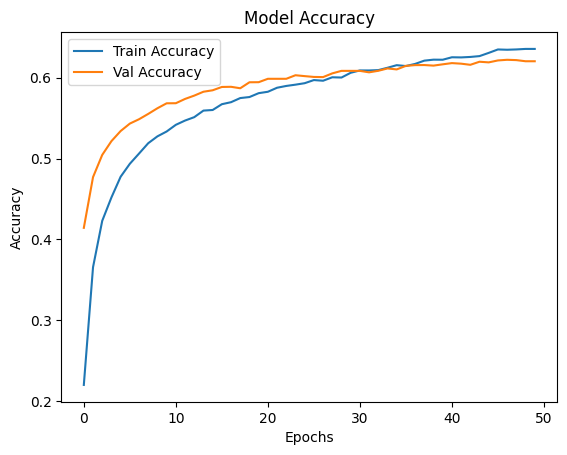

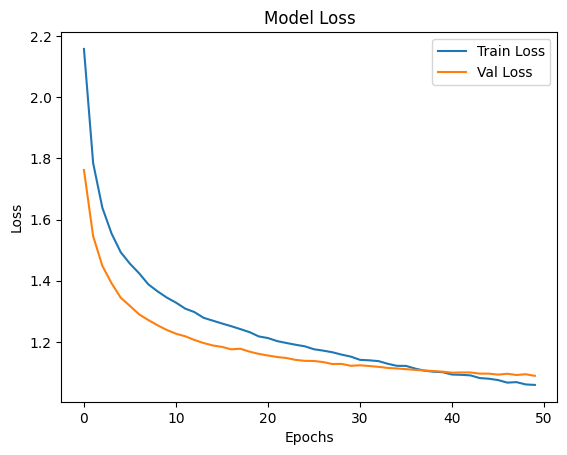

In [103]:
#visualize the training and validation accuracy and loss to see how well the model has learned
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [104]:
#Save the best model. ModelCheckpoint - (best_model.keras) contains the version with the lowest validation loss.
from tensorflow.keras.models import load_model

# Load the saved best model
best_model = load_model('best_model.keras')


Fine-tuning to help the model adapt the pre-trained knowledge to ours

In [105]:
#If the validation accuracy isn’t as high as expected or if you want to push it further
# Unfreeze the last few layers of the VGG16 model
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Freeze all but the last 4 layers
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train again (fine-tune)
history_fine_tune = model.fit(X_train, y_train,
                              epochs=10,
                              batch_size=64,
                              validation_data=(X_test, y_test),
                              callbacks=[reduce_lr, early_stopping])


Epoch 1/10
782/782 [==============================] - 106s 134ms/step - loss: 1.0216 - accuracy: 0.6496 - val_loss: 0.9840 - val_accuracy: 0.6560 - lr: 1.0000e-05
Epoch 2/10
782/782 [==============================] - 107s 136ms/step - loss: 0.9041 - accuracy: 0.6910 - val_loss: 0.9368 - val_accuracy: 0.6759 - lr: 1.0000e-05
Epoch 3/10
782/782 [==============================] - 106s 136ms/step - loss: 0.8328 - accuracy: 0.7135 - val_loss: 0.9014 - val_accuracy: 0.6924 - lr: 1.0000e-05
Epoch 4/10
782/782 [==============================] - 106s 136ms/step - loss: 0.7718 - accuracy: 0.7348 - val_loss: 0.8782 - val_accuracy: 0.7003 - lr: 1.0000e-05
Epoch 5/10
782/782 [==============================] - 108s 138ms/step - loss: 0.7207 - accuracy: 0.7511 - val_loss: 0.8525 - val_accuracy: 0.7130 - lr: 1.0000e-05
Epoch 6/10
782/782 [==============================] - 107s 136ms/step - loss: 0.6734 - accuracy: 0.7652 - val_loss: 0.8357 - val_accuracy: 0.7169 - lr: 1.0000e-05
Epoch 7/10
782/782 [==

313/313 [==============================] - 12s 39ms/step


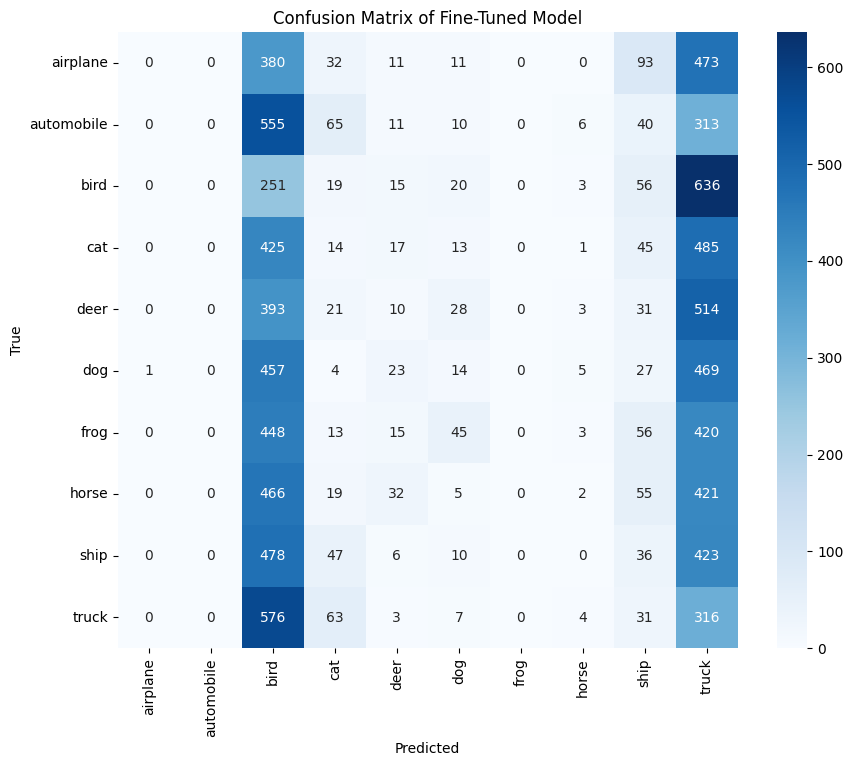

In [107]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = transfer_model.predict(X_test)
y_pred_classes_fine_tuned = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming one-hot encoding for y_test

# Generate the confusion matrix for the fine-tuned model


cm_fine_tuned = confusion_matrix(y_true, y_pred_classes_fine_tuned)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_fine_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Fine-Tuned Model')
plt.show()


Comparing Confusion Matrices Before and After Fine-Tuning


313/313 [==============================] - 12s 38ms/step
Confusion Matrix for Original Model:


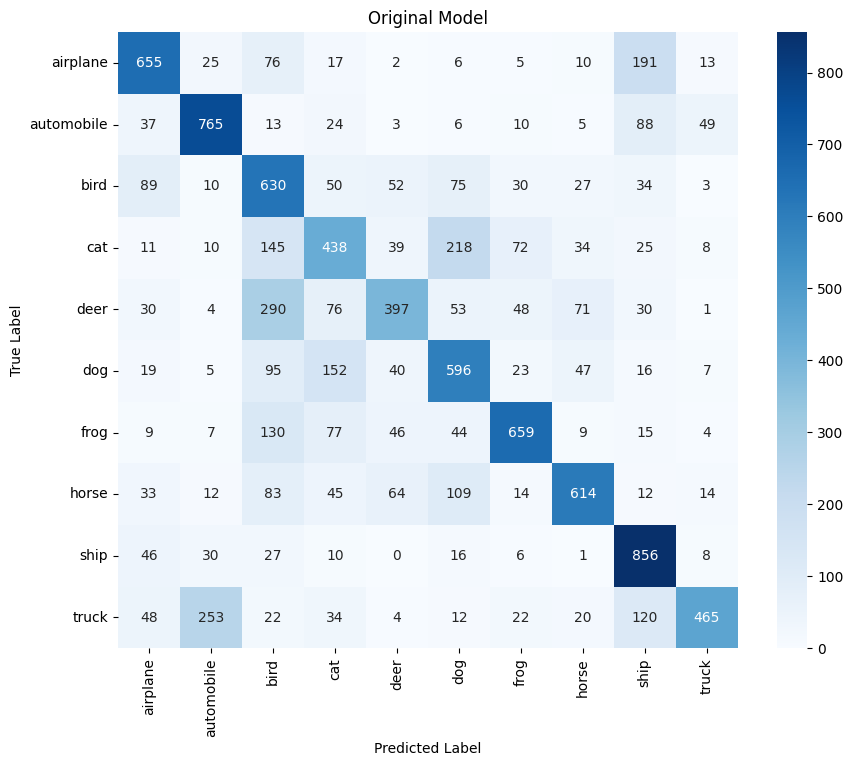

Confusion Matrix for Transfer Learning Model (VGG16):


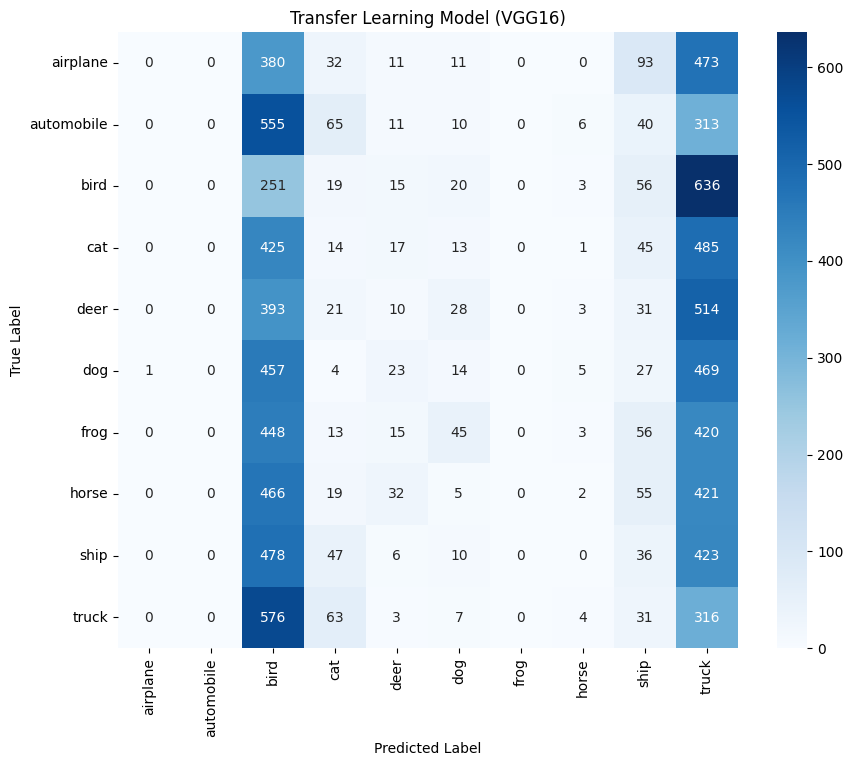

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Step 1: Generate predictions for both models on the test data
y_true = np.argmax(y_test, axis=1)  # True labels (from one-hot encoded format)

# Predictions from original model
y_pred_original = np.argmax(best_model.predict(X_test), axis=1)

# Predictions from transfer model (VGG16 or other transfer learning model)
y_pred_transfer = np.argmax(transfer_model.predict(X_test), axis=1)

# Step 2: Generate confusion matrices for both models
conf_matrix_original = confusion_matrix(y_true, y_pred_original)
conf_matrix_transfer = confusion_matrix(y_true, y_pred_transfer)

# Step 3: Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_class_names, yticklabels=cifar10_class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# CIFAR-10 class names (you can adjust this if needed)
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Step 4: Plot and compare the confusion matrices
print("Confusion Matrix for Original Model:")
plot_confusion_matrix(conf_matrix_original, "Original Model")

print("Confusion Matrix for Transfer Learning Model (VGG16):")
plot_confusion_matrix(conf_matrix_transfer, "Transfer Learning Model (VGG16)")


Plotting history before and after fine-tuning